# Deep Learning Assignment 2 - Part C: Model Classifier

This notebook covers Part C: Building a BERT-based classifier to identify the source model of a generated caption.

## 1. Setup and Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import os
import time
import datetime

## 2. Load and Prepare Data

In [3]:
!pip install -q gdown

# data(from part B) stored in gdrive 
file_id = "11KSaN3uj2--eOkvLfMRtFDxxCioPHnVD"
!gdown {file_id} --output final_raw_results.csv

Downloading...
From: https://drive.google.com/uc?id=11KSaN3uj2--eOkvLfMRtFDxxCioPHnVD
To: /kaggle/working/final_raw_results.csv
100%|███████████████████████████████████████| 2.07M/2.07M [00:00<00:00, 156MB/s]


In [4]:
PART_B_OUTPUT_FILE = "final_raw_results.csv" 
SEPARATOR = " <SEP> "

LABEL_SMOLVLM = 0
LABEL_CUSTOM = 1

try:
    print(f"Loading data from {PART_B_OUTPUT_FILE}...")
    df_in = pd.read_csv(PART_B_OUTPUT_FILE)
    print(f"Loaded {len(df_in)} records.")
    # Display first few rows to check columns
    print("\nOriginal Data Columns:")
    print(df_in.head())
except FileNotFoundError:
    print(f"Error: Cannot find the input file '{PART_B_OUTPUT_FILE}'. Please ensure it exists.")
    df_in = None

classifier_data = []

for index, row in df_in.iterrows():
    input_text_smol = f"{row['original_caption']}{SEPARATOR}{row['generated_caption_smolvlm']}{SEPARATOR}{row['perturbation_percentage']}"
    classifier_data.append({'text': input_text_smol, 'label': LABEL_SMOLVLM, 'image_id': row['image_id']})

    input_text_custom = f"{row['original_caption']}{SEPARATOR}{row['generated_caption_custom']}{SEPARATOR}{row['perturbation_percentage']}"
    classifier_data.append({'text': input_text_custom, 'label': LABEL_CUSTOM, 'image_id': row['image_id']})

# to df
df_classifier_input = pd.DataFrame(classifier_data)

# just shuffle it 
df_classifier_input = df_classifier_input.sample(frac=1, random_state=42).reset_index(drop=True) # Use a fixed random state for reproducibility

print(f"\nCreated classifier input data with {len(df_classifier_input)} total examples.")
print("\nClassifier Input Data Format:")
print(df_classifier_input.head())

Loading data from final_raw_results.csv...
Loaded 2784 records.

Original Data Columns:
     image_id                                   original_caption  \
0  test_1.jpg  A large building with bars on the windows in f...   
1  test_2.jpg  A person is skiing through the snow. There is ...   
2  test_3.jpg  There is a bed in a room against a wall. There...   
3  test_4.jpg  A black and red train is on the tracks and has...   
4  test_5.jpg  A white and yellow public transportation bus w...   

                           generated_caption_smolvlm  \
0  A photo of a building with a parking lot in fr...   
1  A skier is skiing down a slope. The skier is w...   
2  bedroom with sliding glass doors. The bedroom ...   
3  a train is pulling into a station. The train i...   
4  A yellow bus with a sign on the front that say...   

                            generated_caption_custom  perturbation_percentage  
0  This is an image of a street. The street has m...                       10  
1  A m

## 3. Split Data (Train/Validation/Test)

Split the data into 70% train, 10% validation, and 20% test sets.

In [5]:
unique_image_ids = df_classifier_input['image_id'].unique()

train_ratio = 0.70
val_ratio = 0.10
test_ratio = 0.20

train_ids, temp_ids = train_test_split(
    unique_image_ids,
    test_size=(1 - train_ratio), 
    random_state=42 
)

rel_test_ratio = test_ratio / (val_ratio + test_ratio)
val_ids, test_ids = train_test_split(
    temp_ids,
    test_size=rel_test_ratio, 
    random_state=42 
)

train_df = df_classifier_input[df_classifier_input['image_id'].isin(train_ids)].reset_index(drop=True)
val_df = df_classifier_input[df_classifier_input['image_id'].isin(val_ids)].reset_index(drop=True)
test_df = df_classifier_input[df_classifier_input['image_id'].isin(test_ids)].reset_index(drop=True)

## 4. Tokenization

Tokenize the input text for BERT using the `google-bert/bert-base-uncased` tokenizer.
We need to process the `text` column from our train, validation, and test sets.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased', do_lower_case=True)

MAX_LEN = 256

def batch_tokenize(df, text_column='text', label_column='label'):
    """Helper function to tokenize a dataframe."""
    texts_list = [str(text) if pd.notna(text) else "" for text in df[text_column].tolist()]
    encoded_batch = tokenizer.batch_encode_plus(
        texts_list,              
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
   )
    labels = torch.tensor(df[label_column].tolist())
    return encoded_batch['input_ids'], encoded_batch['attention_mask'], labels


train_input_ids, train_attention_mask, train_labels = batch_tokenize(train_df)
val_input_ids, val_attention_mask, val_labels = batch_tokenize(val_df)
test_input_ids, test_attention_mask, test_labels = batch_tokenize(test_df)
print(f"Tokenization done!\n")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenization done!



## 5. Setting up DataLoaders

Creating DataLoader objects for the training, validation, and testing sets to handle batching during model training and evaluation.


In [7]:
BATCH_SIZE = 16  

train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE)

validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=BATCH_SIZE)

print("Created DataLoaders:")
print(f"  Train DataLoader: {len(train_dataloader)} batches")
print(f"  Validation DataLoader: {len(validation_dataloader)} batches")
print(f"  Test DataLoader: {len(test_dataloader)} batches")

Created DataLoaders:
  Train DataLoader: 244 batches
  Validation DataLoader: 35 batches
  Test DataLoader: 70 batches


## 6. Classifier Model

Define the custom BERT-based classifier model architecture as required by the assignment.
It uses the pre-trained 'google-bert/bert-base-uncased' model and adds a classification head.


In [8]:
class CaptionClassifier(nn.Module):
    def __init__(self, bert_model_name='google-bert/bert-base-uncased', num_classes=2):
        super(CaptionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob if hasattr(self.bert.config, 'hidden_dropout_prob') else 0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        logits = self.classifier(output)

        return logits

## 7. Define Training and Evaluation Functions 
#### (`train_classifier`, `evaluate_classifier`)

Define the required functions for training and evaluating the classifier model.

In [10]:
def train_classifier(model, dataloader, optimizer, criterion, device, epochs):
    print(f"\nStarting Training for {epochs} epochs")
    global validation_dataloader
    global scheduler

    training_stats = []

    for epoch_i in range(0, epochs):
        print(f"Training {epoch_i+1}")
        total_train_loss = 0
        model.train()

        progress_bar = tqdm(dataloader, desc=f"  Epoch {epoch_i+1} Training", leave=False)
        for step, batch in enumerate(progress_bar):

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            logits = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            loss = criterion(logits, b_labels) # Use the passed 'criterion'
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            if 'scheduler' in globals() and scheduler is not None:
                 scheduler.step()
            progress_bar.set_postfix({'loss': loss.item()})    


        avg_train_loss = total_train_loss / len(dataloader)
        print(f"\n    Average training loss: {avg_train_loss:.4f}")

        if 'validation_dataloader' in globals() and validation_dataloader is not None:
            print("\nRunning Validation...")
            model.eval() 
            total_eval_accuracy = 0
            total_eval_loss = 0

            val_progress_bar = tqdm(validation_dataloader, desc=f"  Epoch {epoch_i+1} Validation", leave=False)
            for batch in val_progress_bar: 
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)

                with torch.no_grad():
                    logits = model(input_ids=b_input_ids, attention_mask=b_input_mask)

                loss = criterion(logits, b_labels) 
                total_eval_loss += loss.item()
                preds = torch.argmax(logits, dim=1).flatten()
                accuracy = (preds == b_labels).cpu().numpy().mean() * 100
                total_eval_accuracy += accuracy

            avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
            avg_val_loss = total_eval_loss / len(validation_dataloader)

            print(f"    Validation Loss: {avg_val_loss:.4f}")
            print(f"    Validation Accuracy: {avg_val_accuracy:.2f}%")

            training_stats.append({
                'epoch': epoch_i + 1, 'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss, 'Valid. Accur.': avg_val_accuracy
            })

    print("\nTraining complete!\n")
    print("\n Training vs. Validation Loss...")
    try:
        train_loss_values = [stat['Training Loss'] for stat in training_stats]
        val_loss_values = [stat['Valid. Loss'] for stat in training_stats]
        epochs_range = range(1, epochs + 1)

        plt.figure(figsize=(10, 5))
        plt.plot(epochs_range, train_loss_values, 'b-o', label="Training Loss")
        plt.plot(epochs_range, val_loss_values, 'g-o', label="Validation Loss")

        plt.title("Training vs. Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.xticks(epochs_range) 
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Could not create plot. Error: {e}")
        print("Collected stats:", training_stats)

In [11]:
def evaluate_classifier(model, dataloader, device):
    model.eval() 
    predictions = []
    actual_labels = []
    t0 = time.time()
    
    eval_progress_bar = tqdm(dataloader, desc="  Testing", leave=False)
    for batch in eval_progress_bar: 
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        preds = np.argmax(logits, axis=1).flatten()
        predictions.extend(preds)
        actual_labels.extend(label_ids)

    precision, recall, f1, _ = precision_recall_fscore_support(
        actual_labels, predictions, average='macro', zero_division=0
    )
    accuracy = accuracy_score(actual_labels, predictions) 

    results = {
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1,
        "accuracy": accuracy 
    }
    return results

### Hyperparameters


In [16]:
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5
EPSILON = 1e-8
BATCH_SIZE = 16
SEED_VAL = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
!pip install hf_xet

In [18]:
num_classes = 2
classifier_model = CaptionClassifier(bert_model_name='google-bert/bert-base-uncased', num_classes=num_classes)
classifier_model.to(DEVICE)

optimizer = AdamW(classifier_model.parameters(), lr = LEARNING_RATE, eps = EPSILON)

total_steps = len(train_dataloader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
criterion = nn.CrossEntropyLoss()

## 8. Train the Classifier


Starting Training for 5 epochs
Training 1


  Epoch 1 Training:   0%|          | 0/244 [00:00<?, ?it/s]


    Average training loss: 0.1823

Running Validation...


  Epoch 1 Validation:   0%|          | 0/35 [00:00<?, ?it/s]

    Validation Loss: 0.1581
    Validation Accuracy: 96.22%
Training 2


  Epoch 2 Training:   0%|          | 0/244 [00:00<?, ?it/s]


    Average training loss: 0.0214

Running Validation...


  Epoch 2 Validation:   0%|          | 0/35 [00:00<?, ?it/s]

    Validation Loss: 0.2367
    Validation Accuracy: 96.22%
Training 3


  Epoch 3 Training:   0%|          | 0/244 [00:00<?, ?it/s]


    Average training loss: 0.0107

Running Validation...


  Epoch 3 Validation:   0%|          | 0/35 [00:00<?, ?it/s]

    Validation Loss: 0.2095
    Validation Accuracy: 96.76%
Training 4


  Epoch 4 Training:   0%|          | 0/244 [00:00<?, ?it/s]


    Average training loss: 0.0004

Running Validation...


  Epoch 4 Validation:   0%|          | 0/35 [00:00<?, ?it/s]

    Validation Loss: 0.1026
    Validation Accuracy: 98.55%
Training 5


  Epoch 5 Training:   0%|          | 0/244 [00:00<?, ?it/s]


    Average training loss: 0.0002

Running Validation...


  Epoch 5 Validation:   0%|          | 0/35 [00:00<?, ?it/s]

    Validation Loss: 0.1003
    Validation Accuracy: 98.55%

Training complete!


 Training vs. Validation Loss...


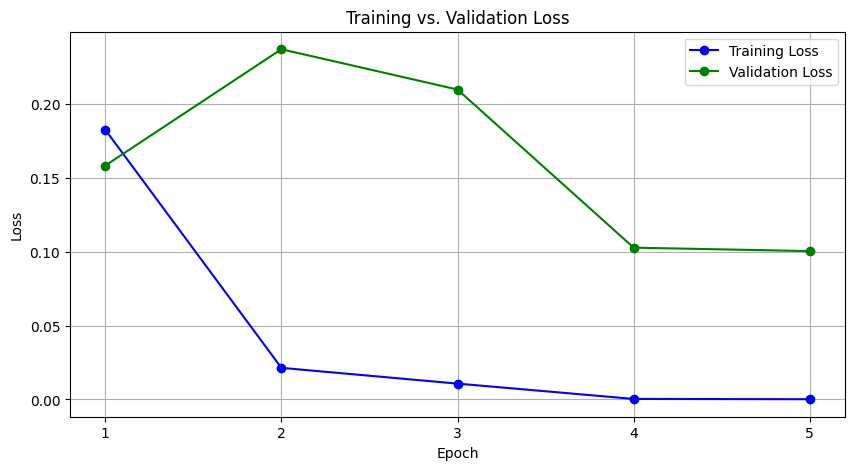


Saving trained model state to bert_caption_classifier_final.pth...
Model saved successfully.


In [19]:
train_classifier(
    model=classifier_model,
    dataloader=train_dataloader,
    optimizer=optimizer,
    criterion=criterion,     
    device=DEVICE,
    epochs=NUM_EPOCHS
)

output_model_file = "bert_caption_classifier_final.pth"
print(f"\nSaving trained model state to {output_model_file}...")
torch.save(classifier_model.state_dict(), output_model_file)
print("Model saved successfully.")

In [20]:
test_results = evaluate_classifier(
    model=classifier_model,
    dataloader=test_dataloader,
    device=DEVICE
)

for key, value in test_results.items():
    print(f"  {key.replace('_', ' ').title()}: {value:.4f}")

  Testing:   0%|          | 0/70 [00:00<?, ?it/s]

  Macro Precision: 0.9861
  Macro Recall: 0.9857
  Macro F1: 0.9857
  Accuracy: 0.9857
